<a href="https://colab.research.google.com/github/johanjun/Google_Machine_Learning_Bootcamp_KR_2021/blob/main/kaggle/RSNA_MICCAI_BRAIN_TUMOR/rsna_miccai_brain_tumor_johanjun_0929_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 4.1 MB/s 


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
import pydicom
import cv2
import pickle

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
data_dir = '/content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai/'

In [ ]:
train_df = pd.read_csv(data_dir + "train_labels.csv")
test_df = pd.read_csv(data_dir + "sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [ ]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [ ]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [ ]:
def load_dicom(path, size = 64): #load DICOM files
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array #returns a numpy.ndarray containing the pixel data
    if np.max(data) != 0:
        data = data / np.max(data) #standardizes so that the pixel values are between 0 and 1
    data = (data * 255).astype(np.uint8) #rescales to 0 and 255
    return cv2.resize(data, (size, size))

In [ ]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join(data_dir + "%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [ ]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [ ]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [ ]:
#pickling
with open(data_dir+'X_T1wCE.pkl', 'rb') as f:
  X_T1wCE = pickle.load(f)

with open(data_dir+'y_T1wCE.pkl', 'rb') as f:
  y_T1wCE = pickle.load(f)

with open(data_dir+'train_idt_T1wCE.pkl', 'rb') as f:
  train_idt_T1wCE = pickle.load(f)

with open(data_dir+'X_test_T1wCE.pkl', 'rb') as f:
  X_test_T1wCE = pickle.load(f)

with open(data_dir+'test_idt_T1wCE.pkl', 'rb') as f:
  test_idt_T1wCE = pickle.load(f)
#pickling
with open(data_dir+'X_FLAIR.pkl', 'rb') as f:
  X_FLAIR = pickle.load(f)

with open(data_dir+'y_FLAIR.pkl', 'rb') as f:
  y_FLAIR = pickle.load(f)

with open(data_dir+'train_idt_FLAIR.pkl', 'rb') as f:
  train_idt_FLAIR = pickle.load(f)

with open(data_dir+'X_test_FLAIR.pkl', 'rb') as f:
  X_test_FLAIR = pickle.load(f)

with open(data_dir+'test_idt_FLAIR.pkl', 'rb') as f:
  test_idt_FLAIR = pickle.load(f)
#pickling
with open(data_dir+'X_T2w.pkl', 'rb') as f:
  X_T2w = pickle.load(f)

with open(data_dir+'y_T2w.pkl', 'rb') as f:
  y_T2w = pickle.load(f)

with open(data_dir+'train_idt_T2w.pkl', 'rb') as f:
  train_idt_T2w = pickle.load(f)

with open(data_dir+'X_test_T2w.pkl', 'rb') as f:
  X_test_T2w = pickle.load(f)

with open(data_dir+'test_idt_T2w.pkl', 'rb') as f:
  test_idt_T2w = pickle.load(f)
#pickling
with open(data_dir+'X_T1w.pkl', 'rb') as f:
  X_T1w = pickle.load(f)

with open(data_dir+'y_T1w.pkl', 'rb') as f:
  y_T1w = pickle.load(f)

with open(data_dir+'train_idt_T1w.pkl', 'rb') as f:
  train_idt_T1w = pickle.load(f)

with open(data_dir+'X_test_T1w.pkl', 'rb') as f:
  X_test_T1w = pickle.load(f)

with open(data_dir+'test_idt_T1w.pkl', 'rb') as f:
  test_idt_T1w = pickle.load(f)

In [ ]:
X = np.concatenate([X_FLAIR, X_T1wCE, X_T2w, X_T1w], axis=0)
y = np.concatenate([y_FLAIR, y_T1wCE, y_T2w, y_T1w], axis=0)
train_idt = np.concatenate([train_idt_FLAIR, train_idt_T1wCE, train_idt_T2w, train_idt_T1w], axis=0)

X_test = np.concatenate([X_test_FLAIR, X_test_T1wCE, X_test_T2w, X_test_T1w], axis=0)
test_idt = np.concatenate([test_idt_FLAIR, test_idt_T1wCE, test_idt_T2w, test_idt_T1w], axis=0)

In [ ]:
X.shape, y.shape, train_idt.shape

((58476, 64, 64), (58476,), (58476,))

In [ ]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X, y, train_idt, test_size=0.05)

In [ ]:
X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [ ]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape

(TensorShape([55552, 64, 64, 1]),
 (55552, 2),
 TensorShape([2924, 64, 64, 1]),
 (2924, 2),
 (55552,),
 (2924,))

In [ ]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    model.add(keras.layers.Conv2D(filters=128, kernel_size=5, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    model.add(keras.layers.Conv2D(filters=512, kernel_size=4, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(2, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)))
    return model

In [ ]:
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 20
N_BATCH = 100
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [ ]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/40
694/694 [==============================] - 15s 19ms/step - loss: 4.1471 - auc_1: 0.5355 - val_loss: 3.2114 - val_auc_1: 0.5941
Epoch 2/40
694/694 [==============================] - 13s 19ms/step - loss: 2.8617 - auc_1: 0.5596 - val_loss: 2.3561 - val_auc_1: 0.6190
Epoch 3/40
694/694 [==============================] - 13s 19ms/step - loss: 2.1036 - auc_1: 0.5890 - val_loss: 1.7721 - val_auc_1: 0.6284
Epoch 4/40
694/694 [==============================] - 13s 19ms/step - loss: 1.5783 - auc_1: 0.6359 - val_loss: 1.3398 - val_auc_1: 0.6703
Epoch 5/40
694/694 [==============================] - 13s 19ms/step - loss: 1.1990 - auc_1: 0.6899 - val_loss: 1.0740 - val_auc_1: 0.6709
Epoch 6/40
694/694 [==============================] - 13s 19ms/step - loss: 0.9245 - auc_1: 0.7462 - val_loss: 0.8594 - val_auc_1: 0.7365
Epoch 7/40
694/694 [==============================] - 13s 19ms/step - loss: 0.7371 - auc_1: 0.7931 - val_loss: 0.7708 - val_auc_1: 0.7158
Epoch 8/40
694/694 [==============

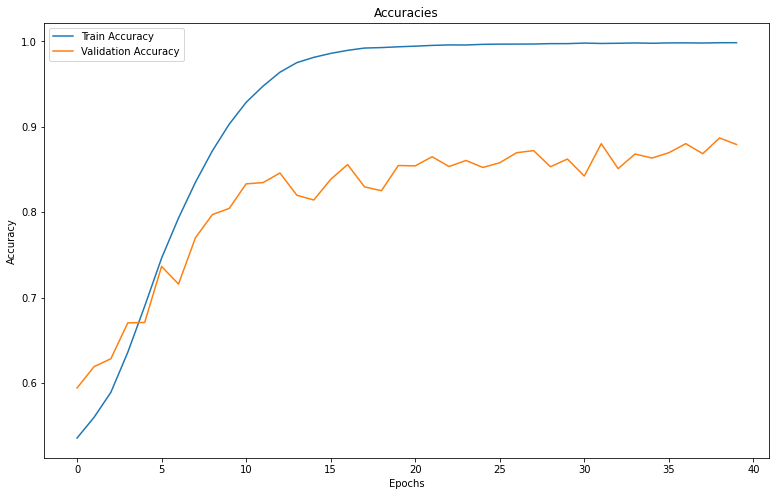

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_1"], label = "Train Accuracy")
plt.plot(history.history["val_auc_1"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

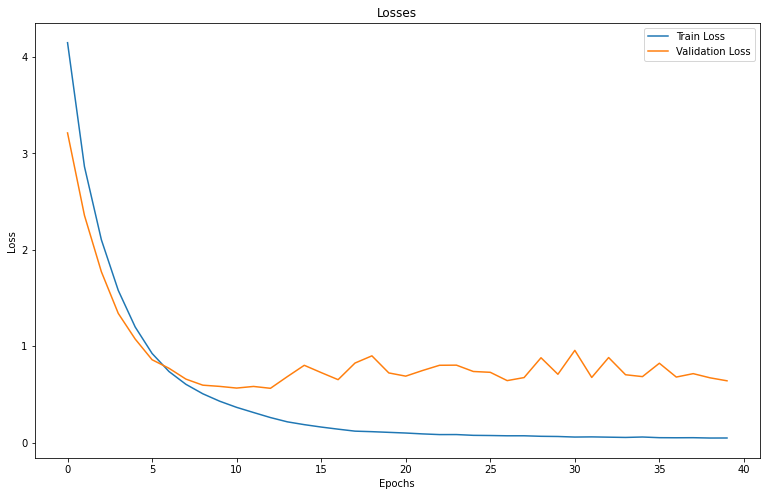

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_valid) #pedict on X_valid
pred = np.argmax(y_pred, axis = 1) #index of largest value by column 열 기준 가장 큰 값의 인덱스

result = pd.DataFrame(train_idt_valid) #BraTS21ID
result[1] = pred #MGMT_value
result.columns=["BraTS21ID","MGMT_value"]

In [ ]:
#Group by BraTS21ID and average + do not use index
result_final = result.groupby("BraTS21ID", as_index = False).mean()
result_final = result_final.merge(train_df, on = "BraTS21ID") #merge train_df

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(result_final.MGMT_value_y, result_final.MGMT_value_x,)

0.9103798162621692

In [ ]:
X_test2 = tf.expand_dims(X_test, axis=-1)

In [ ]:
#submission
sample_sub = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

y_pred = model.predict(X_test2) #predict test
pred = np.argmax(y_pred, axis = 1)

result = pd.DataFrame(test_idt)
result[1] = pred

result.columns=["BraTS21ID","MGMT_value"]
result_final = result.groupby("BraTS21ID",as_index = False).mean()

result_final["BraTS21ID"] = sample_sub["BraTS21ID"]
result_final["MGMT_value"] = result_final["MGMT_value"]
result_final

,BraTS21ID,MGMT_value
0,1,0.909091
1,13,0.909091
2,15,0.901961
3,27,0.921569
4,37,0.954545
...,...,...
82,826,0.857143
83,829,0.800000
84,833,0.375000
85,997,0.500000


In [ ]:
result_final.to_csv("submission.csv",index=False)